# Ground Models

The ground models in PyWake are used to model the effects that the ground has on the inflow and wake.

**Install PyWake if needed**

In [1]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

### Mirror
The Mirror ground model allows enforcing a slip boundary condition (zero wall normal velocity) at the ground level. This is achieved by mirroring the turbine in the ground plane, an approach from potential flow theory.  

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Here it is shown for a turbine with wake and blockage. 

Text(0, 0.5, 'y [m]')

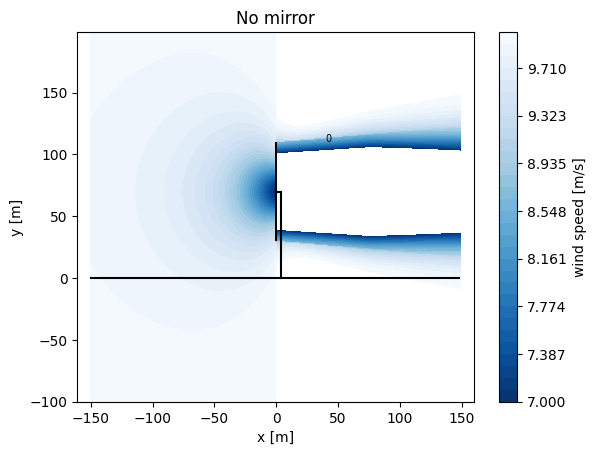

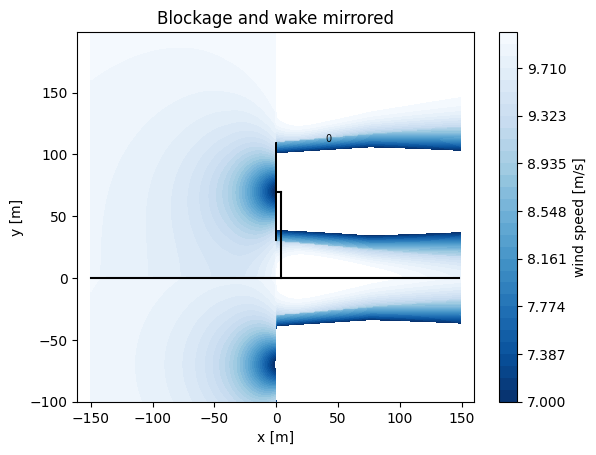

In [3]:
from py_wake.ground_models import Mirror
from py_wake.wind_farm_models import All2AllIterative
from py_wake.deficit_models import SelfSimilarityDeficit2020, NiayifarGaussianDeficit
from py_wake.turbulence_models import CrespoHernandez
from py_wake.flow_map import YZGrid

from py_wake.examples.data.hornsrev1 import V80, Hornsrev1Site

site = Hornsrev1Site()
windTurbines = V80()
wt_x, wt_y = site.initial_position.T

#----------
wfm = All2AllIterative(site, windTurbines, 
                       wake_deficitModel=NiayifarGaussianDeficit(), 
                       blockage_deficitModel=SelfSimilarityDeficit2020(),
                       turbulenceModel=CrespoHernandez())
plt.figure()
plt.title('No mirror')
ws = 10.
levels = np.linspace(7., 10., 32)
x, y, z = 0, np.arange(-150, 150, 1), np.arange(-100, 200)
wfm([0], [0], wd=180., ws=ws).flow_map(YZGrid(x=x, y=y + .1, z=z)).plot_wake_map(levels=levels)
plt.xlabel('x [m]')
plt.ylabel('y [m]')

#----------
wfm = All2AllIterative(site, windTurbines, 
                       wake_deficitModel=NiayifarGaussianDeficit(groundModel=Mirror()), 
                       blockage_deficitModel=SelfSimilarityDeficit2020(groundModel=Mirror()),
                       turbulenceModel=CrespoHernandez())

plt.figure()
plt.title('Blockage and wake mirrored')
wfm([0], [0], wd=180., ws=ws).flow_map(YZGrid(x=x, y=y + .1, z=z)).plot_wake_map(levels=levels)
plt.xlabel('x [m]')
plt.ylabel('y [m]')

However, many wake models have been calibrated including ground effects and thus do usually not requiere a ground model. In fact this can lead to double counting, leading to excessive deficits. 
Blockage models on the other hand are usually calibrated without ground effects and need a ground model. This is why in PyWake one can set the ground model for blockage and wakes independantly. 

Text(0, 0.5, 'y [m]')

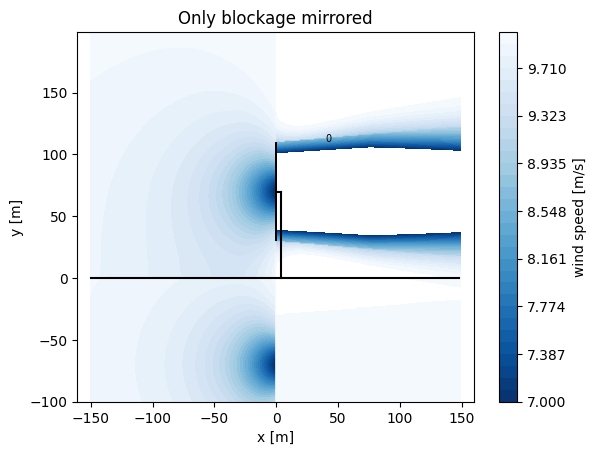

In [4]:
#----------
wfm = All2AllIterative(site, windTurbines, 
                       wake_deficitModel=NiayifarGaussianDeficit(), 
                       blockage_deficitModel=SelfSimilarityDeficit2020(groundModel=Mirror()),
                       turbulenceModel=CrespoHernandez())

plt.figure()
plt.title('Only blockage mirrored')
wfm([0], [0], wd=180., ws=ws).flow_map(YZGrid(x=x, y=y + .1, z=z)).plot_wake_map(levels=levels)
plt.xlabel('x [m]')
plt.ylabel('y [m]')

### MultiMirror

To model additional blocking effect from relatively low and strong temperature inversions in the atmoshperic boundary layer - something first proposed by the Offshore Wind Accelerator (OWA) - another mirror plane could be added above the turbine.

The following scripts runs the `SelfSimilarity2020()` blockage model with different ground models. Either without any mirrors, with the usual ground mirror and the `MultiMirror()` class. It takes the height of the mirror aloft as an input and how many times the extra mirrors should be reflected in each other. By default only the ground and mirror aloft are enforced,  (`n_mirrors = 2 + n_reps`). Be aware that the number of turbines grows quickly, such that for a single turbine the actual number becomes `n_turbines = 2^(n_mirrors)`. There is also a verification setup where the imaginary turbines are explicity defined and placed in the horizontal plane instead (only equivalent to `n_reps=0`).   

Compared are contours of normalised deficit in very close proximity to the rotor. The thrust is set very high,`ct=1.`, and the mirror plane just above the rotor to emphasize changes.   

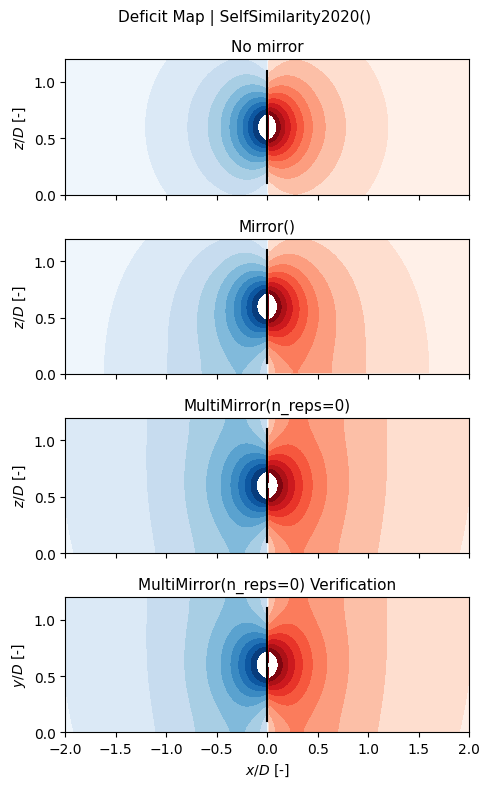

In [5]:
from matplotlib import cm
from matplotlib.colors import ListedColormap

from py_wake.deficit_models.no_wake import NoWakeDeficit
from py_wake.ground_models import MultiMirror
from py_wake.flow_map import XYGrid, XZGrid
from py_wake.wind_turbines import WindTurbine
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular
from py_wake.site._site import UniformSite

# create dummy sites and turbine
class Dummy(WindTurbine):
    def __init__(self, name='dummy', ct=1.0, D=1., zh=1.5):
        WindTurbine.__init__(self, name=name, diameter=D,
                             hub_height=zh, powerCtFunction=PowerCtTabular([-100, 100], [0, 0], 'kW', [ct, ct]))

class BastankhahSite(UniformSite):
    def __init__(self, ws=1., ti=0.1):
        UniformSite.__init__(self, ti=ti, ws=ws)


ct = 1.
D = 1.
hub_height = 0.6 * D
mirror_height = 1.2 * D

x = np.linspace(-2.* D, 2. * D, 401)
y = np.linspace(0., 1.2 * D, 201)
hgrid = XYGrid(x=x, y=y)
vgrid = XZGrid(0.0, x=x, z=y)

bmodels = {
           "No mirror" : SelfSimilarityDeficit2020(),
           "Mirror()" : SelfSimilarityDeficit2020(groundModel=Mirror()),
           "MultiMirror(n_reps=0)" : SelfSimilarityDeficit2020(groundModel=MultiMirror(mirror_height, n_reps=0)),
           "MultiMirror(n_reps=0) Verification" : SelfSimilarityDeficit2020(),
}
wfms = []
for name, bmodel in bmodels.items():
    wfms.append(All2AllIterative(BastankhahSite(), Dummy(ct=ct, D=D, zh=hub_height), 
                                 wake_deficitModel=NoWakeDeficit(), 
                                 blockage_deficitModel=bmodel))   

fms = []
for i in range(len(wfms) - 1):
    fms.append(wfms[i](x=[0], y=[0], wd=270., ws=1.).flow_map(vgrid))
wt_y = [hub_height, 
        -hub_height, 
        mirror_height + (mirror_height - hub_height), 
        mirror_height + (mirror_height - hub_height) + 2 * hub_height]
fms.append(wfms[-1](x=[0, 0, 0, 0], y=wt_y, 
                    wd=270., ws=1.).flow_map(hgrid))


cmap = np.r_[cm.Reds_r(np.linspace(-0,1,127)),[[1,1,1,1],[1,1,1,1]],cm.Blues(np.linspace(-0,1,128))]
levels=np.linspace(-0.35, 0.35, 21)
fig, ax = plt.subplots(len(fms), 1, sharex=True, sharey=True, figsize=(5, 8))

for i, (name, model) in enumerate(bmodels.items()):
    if i < len(bmodels) - 1:
        ax[i].contourf(fms[i].x / D, fms[i].h / D, 1. - np.squeeze(fms[i].WS_eff), 
                    cmap=ListedColormap(cmap), levels=levels)
        ax[i].plot([0, 0], [-D / 2. + hub_height, D / 2. + hub_height], 'k-')
        ax[i].set_ylabel('$z/D$ [-]')
    else:
        ax[i].contourf(fms[i].x / D, fms[i].y / D, 1. - np.squeeze(fms[i].WS_eff), 
                    cmap=ListedColormap(cmap), levels=levels)
        ax[i].plot([0, 0], [-D / 2. + hub_height, D / 2. + hub_height], 'k-')
        ax[i].set_ylabel('$y/D$ [-]')
    
    ax[i].set_title(name, fontsize=11)
    
ax[-1].set_xlabel('$x/D$ [-]')
fig.suptitle('Deficit Map | SelfSimilarity2020()', fontsize=11)
fig.tight_layout()